# Volume 4: Finite Difference Method
    Daniel Perkins
    MATH 437
    10/6/24

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import linalg as spla

In [2]:
%matplotlib inline

# Problem 1

Let $u(x) = sin((x + \pi)^2 - 1)$. Use (1.3) - (1.6) to approximate $\frac{1}{2}
u'' − u'$ at the grid points where $a = 0$, $b = 1$, and $n = 10$. Graph the result.

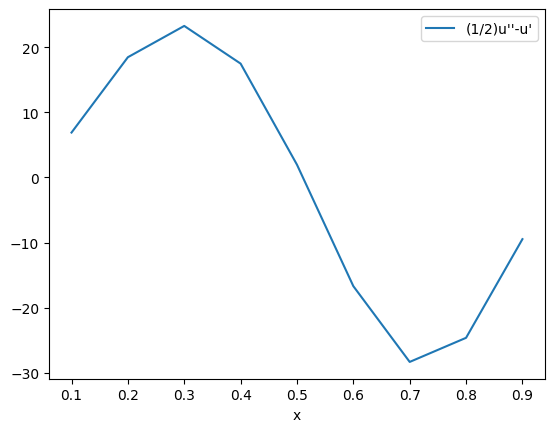

In [46]:
def u(x):   # Define u(x)
    return np.sin((x + np.pi)**2 - 1)
# Get grid points
n = 10
xs = np.linspace(0, 1, n + 1)
h = xs[1] - xs[0]

# Create sparse matrix and set up equation 8.4
A = sparse.diags([-1 * np.ones(n-2), np.ones(n-2)], [-1, 1], shape=(n-1, n-1))
v = np.array(u(xs[1:-1]))
w = np.zeros_like(v)
w[0], w[-1] = -u(xs[0])/(2*h), -u(xs[-1])/(2*h)
u_prime = (1 / (2*h)) * A @ v + w

# Create sparse matrix and set up equation 8.6.
A2 = sparse.diags([np.ones(n-2), -2*np.ones(n), np.ones(n-2)], [-1, 0, 1], shape=(n-1, n-1))
w2 = np.zeros_like(v)
w2[0], w2[-1] = u(xs[0])/(h**2), u(xs[-1])/(h**2)
u_prime2 = (1 / (h**2)) * A2 @ v + w2

# Plot things
# plt.plot(xs, u(xs), label="u(x)")
# plt.plot(xs[1:-1], u_prime, label="u'(x)")
# plt.plot(xs[1:-1], u_prime2, label="u''(x)")
plt.plot(xs[1:-1], 0.5*u_prime2 - u_prime, label="(1/2)u''-u'")
plt.xlabel("x")
plt.legend()
plt.show()

# Problem 2

Equation (1.7) is the singularly perturbed boundary value problem
\begin{align*}
	&{ } \varepsilon u''(x)-u(x)'= f(x), \quad x \in (0,1), \\
	&{ } u(0) = \alpha, \quad u(1) = \beta.
\end{align*}

Use equation (1.9) to solve the singularly perturbed BVP (1.7) on $[0,1]$ with $\varepsilon = 1/10, f(x) = -1, \alpha=1,$ and $\beta=3$ on a grid with $n=30$ subintervals. Graph the solution. This BVP is called singularly perturbed because of the location of the parameter $\varepsilon$. For $\varepsilon=0$ the ODE has a drastically different character - it then becomes first order, and can no longer support two boundary conditions.

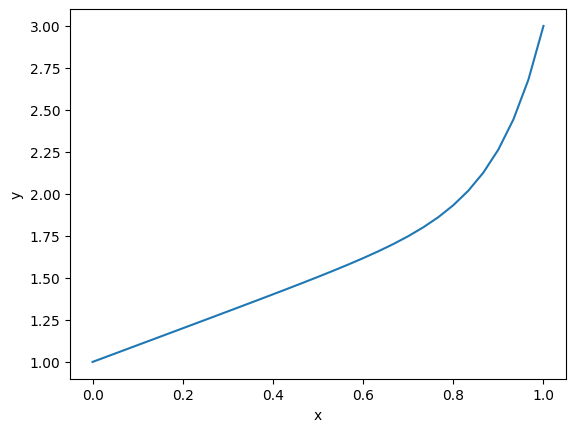

In [60]:
# Initialize variables
def f(x):
    return -1*np.ones_like(x)
e = 1/10.
a = 1
b = 3
n = 30
xs = np.linspace(0, 1, n + 1)
h = xs[1] - xs[0]

# Create sparse matrix and set up equation 8.9
A = sparse.diags([e + h/2, -2*e, e - h/2], [-1, 0, 1], shape=(n-1, n-1))
fs = f(np.ones(n-1))
fs[0] = fs[0] - a*(e + h/2)/h**2
fs[-1] = fs[-1] - b*(e - h/2)/h**2
U = spla.spsolve((1/h**2)*A, fs)
U = np.concatenate(([a], U, [b]))   # Add endpoints

# Plot things
plt.plot(xs, U)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Problem 3

Implement a function `singular_bvp` to compute the finite difference solution to (1.7).
Using $n = 5 \times 2^0,5 \times 2^1, \dots ,5 \times 2^9$ subintervals, compute 10 approximate solutions.
Use these to visualize the $\mathcal{O}(h^2)$ convergence of the finite difference method from Problem 2 by producing a loglog plot of error against subinterval count; this will be similar to Figure 2, except with $\varepsilon=0.1$. 

To produce the plot, treat the approximation with $n = 5 \times 2^9$ subintervals as the "true solution", and measure the error for the other approximations against it. ote that, since the ratios of numbers of subintervals between approximations are multiples of 2, we can compute the $L_{\infty}$ error for the $n=5 \times 2^j$ approximation by using the `step` argument in the array slicing syntax:

    # best approximation; the vector has length 5*2^9+1
    sol_best = singular_bvp(eps,alpha,beta,f,5*(2**9))

    # approximation with 5*(2^j) intervals; the vector has length 5*2^j+1
    sol_approx = singular_bvp(eps,alpha,beta,f,5*(2**j))

    # approximation error; slicing results in a vector of length 5*2^j+1,
    #    which allows it to be compared
    error = np.max(np.abs(sol_approx - sol_best[::2**(9-j)]))


In [98]:
def singular_bvp(eps, alpha, beta, f, n):
    """
    Solves the singularly perturbed BVP (1.7) on the interval [0,1] using finite differences.
    
    Parameters:
        eps (float): the singular perturbation parameter of the BVP.
        alpha (float): the boundary value of u at x=0.
        beta (float): the boundary value of u at x=1.
        f (callable): the right-hand function of the BVP.
        n (int): the number of subintervals to use in the finite differences method.
        
    Returns:
        ((n+1,) ndarray): the approximated solution to the BVP, including the boundary points.
    """
    xs = np.linspace(0, 1, n + 1)
    h = xs[1] - xs[0]

    # Create sparse matrix and set up equation 8.9
    A = sparse.diags([eps + h/2, -2*eps, eps - h/2], [-1, 0, 1], shape=(n-1, n-1))
    fs = f(xs[1:-1])
    fs[0] = fs[0] - alpha*(eps + h/2)/h**2
    fs[-1] = fs[-1] - beta*(eps - h/2)/h**2
    U = spla.spsolve((1/h**2)*A, fs)
    U = np.concatenate(([a], U, [b]))   # Add endpoints

    return U

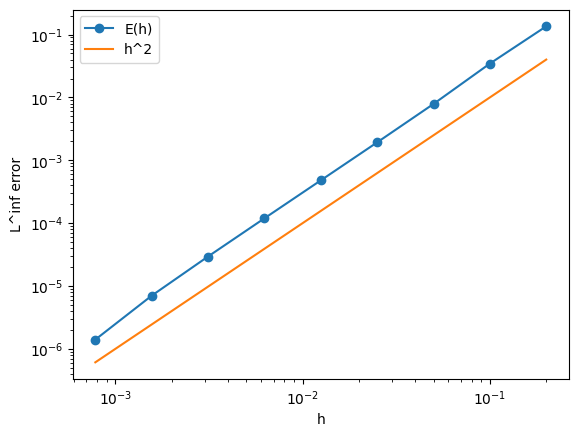

In [99]:
ns = np.array([5 * 2**n for n in range(10)])
eps = 1/10.
alpha = 1
beta = 3
def f(x):
    return -1*np.ones_like(x)

# Get estimate for each n value
solutions = []
for n in ns:
    solutions.append(singular_bvp(eps, alpha, beta, f, n))
true_solution = solutions[-1]  # Treat last one as the true solution
    
mask = 9  # Used to determine how to compare output
errors = []
for solution in solutions[:-1]:
    solution_to_compare = true_solution[::2**mask]  # We only can compare certain entries.
    error = np.max(np.abs(solution - solution_to_compare))
    errors.append(error)
    mask -= 1
    

plt.loglog(1 / ns[:-1], errors, marker="o", label="E(h)")
plt.loglog(1 / ns[:-1], (1 / ns[:-1])**2, label="h^2")
plt.xlabel("h")
plt.ylabel("L^inf error")
plt.legend()
plt.show()

# Problem 4

Extend your finite difference code to the case of a general second order linear BVP with boundary conditions:

\begin{align*}
	&{ } a_1(x)y''(x) +a_2(x)y'(x)+ a_3(x) y(x) = f(x), \quad x \in (a,b),\\
	&{ } y(a) = \alpha, \quad y(b) = \beta.
\end{align*}

Use your code to solve the boundary value problem

\begin{align*}
	\varepsilon y''(x) - 4(\pi - x^2)y(x) = \cos x, \\
	y(0) = 0, \quad y(\pi/2) = 1,
\end{align*}

for $\varepsilon = 0.1$ on a grid with $n=30$ subintervals. Plot your solution.

In [138]:
def bvp(a, b, alpha, beta, a1, a2, a3, f, n):
    """
    Computes the solution to the BVP:
        
        a1(x)y'' + a2(x)y' + a3(x)y = f
        y(a) = α, y(b) = β
        
    using finite differences.
    
    Parameters:
        a, b (float): the left and right boundary points.
        alpha (float): the boundary value of y at x=a.
        beta (float): the boundary value of y at x=b.
        f (callable): the right-hand function of the BVP.
        a1, a2, a3 (callable): the coefficient functions of the BVP.
        n (int): the number of subintervals to use in the finite differences method.
        
    Returns:
        ((n+1,) ndarray): the approximated solution to the BVP, including the boundary points.
    """
    xs = np.linspace(a, b, n + 1)
    h = xs[1] - xs[0]

    # Make the sparse matrix and right vector
    left_diagonal = a1(xs[2:-1]) - (h/2)*a2(xs[2:-1])
    diagonal = -2*a1(xs[1:-1]) + (h**2)*a3(xs[1:-1])
    right_diagonal = a1(xs[1:-2]) + (h/2)*a2(xs[1:-2])
    A = sparse.diags([left_diagonal, diagonal, right_diagonal], offsets=[-1, 0, 1])
    fs = f(xs[1:-1])
    fs[0] = fs[0] - alpha*((a1(xs[1]) / h**2) - (a2(xs[1]) / (2*h)))
    fs[-1] = fs[-1] - beta*((a1(xs[-2]) / h**2) - (a2(xs[-2]) / (2*h)))
    
    # Solve the system
    U = spla.spsolve((1/h**2)*A, fs)
    U = np.concatenate(([alpha], U, [beta]))   # Add endpoints

    return U

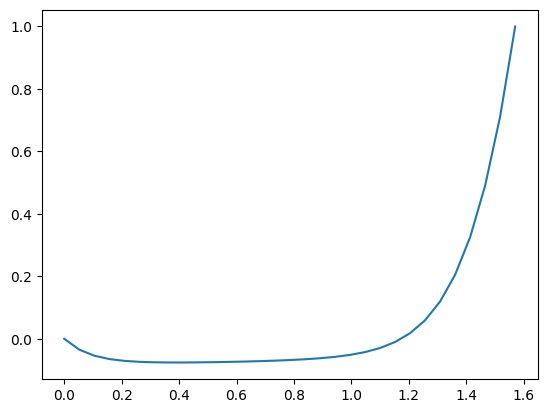

In [139]:
# Initialize the variables
a = 0
b = np.pi/2
n = 30
eps = 1/10.
alpha = 0
beta = 1
def f(x): return np.cos(x)
def a1(x): return eps*np.ones_like(x)
def a2(x): return 0*np.ones_like(x)
def a3(x): return -4*(np.pi - x**2)

# Get estimate for each n value
solution = bvp(a, b, alpha, beta, a1, a2, a3, f, n)

plt.plot(np.linspace(a, b, n+1), solution)
plt.show()

# Problem 5

Numerically solve the boundary value problem

\begin{align*}
	\varepsilon y''(x) + xy'(x) = -\varepsilon \pi^2 \cos(\pi x) - \pi x \sin(\pi x), \\
	y(-1) = -2, \quad y(1) = 0,
\end{align*}

for $\varepsilon = 0.1, 0.01,$ and $0.001$. Use a grid with $n=150$ subintervals. Plot your solutions.

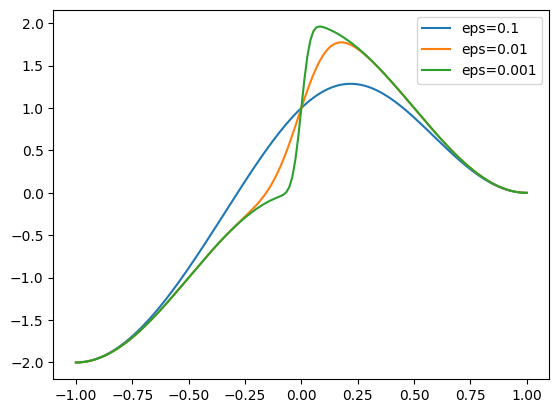

In [143]:
# Initialize the variables
a = -1
b = 1
alpha = -2
beta = 0
n = 150
def a2(x): return x
def a3(x): return 0*np.ones_like(x)

for eps in [0.1, 0.01, 0.001]:
    def f(x): return -eps*(np.pi)**2*np.cos(np.pi*x) - np.pi*x*np.sin(np.pi*x)
    def a1(x): return eps*np.ones_like(x)

    # Get estimate for each n value
    solution = bvp(a, b, alpha, beta, a1, a2, a3, f, n)
    plt.plot(np.linspace(a, b, n+1), solution, label=f"eps={eps}")
    
plt.legend()
plt.show()

# Problem 6

Numerically solve the boundary value problem

\begin{align*}
	(\varepsilon +x^2)y''(x) + 4xy'(x) + 2y(x) = 0, \\
	y(-1) = 1/(1+\varepsilon), \quad y(1) = 1/(1+\varepsilon),
\end{align*}

for $\epsilon = 0.05$ and $0.02$. Use a grid with $n=150$ subintervals. Plot your solutions.

/home/dbp52/.acme-venv/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:214: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


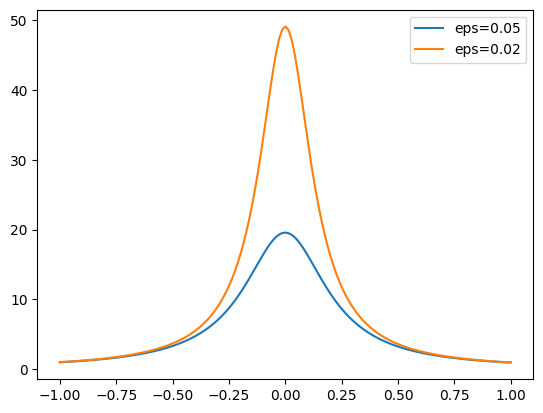

In [144]:
# Initialize the variables
a = -1
b = 1
n = 150
def f(x): return 0*np.ones_like(x)
def a2(x): return 4*x
def a3(x): return 2*np.ones_like(x)

for eps in [0.05, 0.02]:
    alpha = 1 / (1 + eps)
    beta = alpha
    def a1(x): return eps + x**2

    # Get estimate for each n value
    solution = bvp(a, b, alpha, beta, a1, a2, a3, f, n)
    plt.plot(np.linspace(a, b, n+1), solution, label=f"eps={eps}")
    
plt.legend()
plt.show()